In [1]:
"""
Use this notebook to train/test/evaluate Deep Learning for signal ID
TRAINED ON GOOGLE COLAB PRO TO ENABLE GPUs and speed up training time
Now training locally on rtx3090
"""
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys
print(sys.version)
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
import cv2


gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(gpus[0])

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
tf.test.is_built_with_cuda()
#print(os.getcwd())

True

In [3]:
#os.chdir("..")
#os.chdir(os. getcwd() + "\\src")
#from c import ROOT_DIR

ROOT_DIR = 'c:\\Users\\endle\\Desktop\\mseisML\\src'
os.chdir(ROOT_DIR)


In [4]:
"""
HRNet model

https://arxiv.org/abs/1908.07919
https://arxiv.org/pdf/1908.07919.pdf
"""

import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    # x = BatchNormalization(axis=3)(x)
    # x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))

    x = stem_net(inputs)

    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

In [5]:
"""
metrtics
"""
import numpy as np
import keras.backend as K


def _true_positives(y_true, y_pred):
    # determine number of matching values and return the sum
    if K.is_tensor(y_pred):
        return K.sum(y_true * K.round(y_pred))
    else:
        return (y_true * np.round(y_pred)).sum()


def _true_negatives(y_true, y_pred):
    # invert and then treat as true positives
    y_true = (y_true - 1) * -1
    y_pred = (y_pred - 1) * -1

    return _true_positives(y_true, y_pred)


def _false_negatives(y_true, y_pred):
    if K.is_tensor(y_pred):
        return K.sum(K.clip((y_true - K.round(y_pred)), 0, 1))
    else:
        return (y_true - np.round(y_pred)).clip(0).sum()


def _false_positives(y_true, y_pred):
    # switch positions and treat as false negatives
    return _false_negatives(y_pred, y_true)


def _calc_mean_metric(y_true, y_pred, metric, starting_label=0):
    switcher = {
        'mPrec': precision,
        # TODO 'mAP': average_precision,
        'mf1': f1,
        'mAcc': accuracy,
        'mBacc': balanced_accuracy,
        'mRec': recall,
        'mIOU': iou,
        'mSpec': specificity,
        'mMcc': mcc
    }

    try:
        func = switcher[metric]
    except KeyError:
        raise ValueError('Unkown Metric')

    if K.is_tensor(y_true):
        amount_labels = K.int_shape(y_pred)[-1]
        batch_size = K.int_shape(y_pred)[0]
        summation = K.variable(0)
        y_pred = K.round(y_pred)
    else:
        amount_labels = y_pred.shape[-1]
        batch_size = y_pred.shape[0]
        summation = 0

    for batch_num in range(batch_size):
        for label in range(starting_label, amount_labels):
            summation = summation + func(
                y_true[batch_num, :, :, label], y_pred[batch_num, :, :, label])

    return summation / (batch_size * amount_labels)


def recall(y_true, y_pred):
    # Recall = TP / P
    if K.is_tensor(y_pred):
        return _true_positives(y_true, y_pred) / K.sum(y_true)
    else:
        return _true_positives(y_true, y_pred) / y_true.sum()


def specificity(y_true, y_pred):
    # Specificity = TN / N = TN / (TN + FN)
    return _true_positives(y_true, y_pred) / (
            _true_negatives(y_true, y_pred) +
            _false_negatives(y_true, y_pred))


def precision(y_true, y_pred):
    # Precision = TP / (TP + FP)
    tp = _true_positives(y_true, y_pred)
    return tp / (tp + _false_negatives(y_true, y_pred))

def iou(y_true, y_pred):
    """homemade IOU"""
    # IOU = TP / (TP + FN + FP)
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
  

# def iou(y_true, y_pred):
#     # IOU = TP / (TP + FN + FP)
#     I = _true_positives(y_true, y_pred)
#     U = I + _false_negatives(y_true, y_pred) + _false_positives(y_true, y_pred)

#     if K.is_tensor(y_pred):
#         return K.switch(K.equal(U, 0), 1.0, I / U)
#     else:
#         return 1 if U is 0 else I / U


def balanced_accuracy(y_true, y_pred):
    # BA = (TPR + TNR) / 2 = (Recall + Specificity) / 2
    return (recall(y_true, y_pred) + specificity(y_true, y_pred)) / 2


def f1(y_true, y_pred):
    # F1 2 * prec * rec / (prec + rec)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec / (prec + rec))


def mcc(y_true, y_pred):
    # mcc = https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    tp = _true_positives(y_true, y_pred)
    fp = _false_positives(y_true, y_pred)
    tn = _true_negatives(y_true, y_pred)
    fn = _false_negatives(y_true, y_pred)
    num = tp * tn - fp * fn
    den = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return num / den


def accuracy(y_true, y_pred):
    # acc = (tp + tn) / tp + fp + tn + fn
    tp = _true_positives(y_true, y_pred)
    fp = _false_positives(y_true, y_pred)
    tn = _true_negatives(y_true, y_pred)
    fn = _false_negatives(y_true, y_pred)

    return (tp + tn) / tp + fp + tn + fn


def mean_mcc(y_true, y_pred):
    """ Calculates the mean accuracy of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean accuracy
    """
    return _calc_mean_metric(y_true, y_pred, 'mMcc')


def mean_accuracy(y_true, y_pred):
    """ Calculates the mean accuracy of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean accuracy
    """
    return _calc_mean_metric(y_true, y_pred, 'mAcc')


def mean_iou(y_true, y_pred):
    """" Calculates the mean IOU of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean IOU
    """
    return _calc_mean_metric(y_true, y_pred, 'mIOU')


def mean_precision(y_true, y_pred):
    """ Calculates the mean precision of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean precision
    """
    return _calc_mean_metric(y_true, y_pred, 'mPrec')


def mean_recall(y_true, y_pred):
    """ Calculates the mean recall of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean recall
    """
    return _calc_mean_metric(y_true, y_pred, 'mRec')


# def mean_average_precision(gt, pred, colours=[[0,0,0], [255,255,255]]):
#     """ Calculates the mean recall of two images for given colours.

#     # Arguments:
#         See parameters in :func:`_calc_mean_metric`

#     # Returns:
#         The mean average precision
#     """
#     return _calc_mean_metric(gt, pred, colours, 'mAP')

def mean_f1(y_true, y_pred):
    """ Calculates the mean f1 score.
    Currently calculates f1 score for each colour and then averages that. Can be calculated in many ways,
    see: http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean f1 score
    """
    return _calc_mean_metric(y_true, y_pred, 'mf1')


def mean_balanced_accuracy(y_true, y_pred):
    """ Calculates the mean f1 score.
    Currently calculates f1 score for each colour and then averages that. Can be calculated in many ways,
    see: http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean f1 score
    """
    return _calc_mean_metric(y_true, y_pred, 'mBacc')


def mean_specificity(y_true, y_pred):
    """ Calculates the mean specificity of two images for given colours.
    # Arguments:
        See parameters in :func:`_calc_mean_metric`
    # Returns:
        The mean specificity
    """
    return _calc_mean_metric(y_true, y_pred, 'mSpec')

In [6]:
"""
Loss
"""

#import tensorflow as tf
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
    loss = 1. - 2 * intersection / (union + K.epsilon())
    return loss


def ce_dice_loss(y_true, y_pred):
    ce_loss = binary_crossentropy(y_true, y_pred)

    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred))
    dice_loss = - tf.log((intersection + K.epsilon()) / (union + K.epsilon()))
    loss = ce_loss + dice_loss
    return loss


def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    loss = 1. - intersection / (union + K.epsilon())
    return loss


def ce_jaccard_loss(y_true, y_pred):
    ce_loss = binary_crossentropy(y_true, y_pred)

    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    jaccard_loss = - tf.math.log((intersection + K.epsilon()) / (union + K.epsilon()))
    loss = ce_loss + jaccard_loss
    return loss


def tversky_loss(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return 1 - (true_pos + K.epsilon())/(true_pos + alpha * false_neg + (1-alpha) * false_pos + K.epsilon())


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [7]:
"""
Add Drive for dataset
"""
# local

ROOT_DIR = 'c:\\Users\\endle\\Desktop\\mseisML'

mask_path = ROOT_DIR + "\\MLdata\\masks\\"
image_path = ROOT_DIR + "\\MLdata\\das\\"

""

# # connect dataset to google drive

# from google.colab import drive
# drive.mount('/content/drive/')


# # once mounted, use these paths

# image_path = '/content/drive/MyDrive/DAS_ML_data/das/'
# mask_path = '/content/drive/MyDrive/DAS_ML_data/masks/'

''

In [8]:
"""
Our dataloader
"""

input_dir = image_path
target_dir = mask_path

input_img_paths = sorted(
    [
        os.path.join(os.sep, input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(os.sep, target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 928
c:\Users\endle\Desktop\mseisML\MLdata\das\0.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\0.png
c:\Users\endle\Desktop\mseisML\MLdata\das\1.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\1.png
c:\Users\endle\Desktop\mseisML\MLdata\das\10.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\10.png
c:\Users\endle\Desktop\mseisML\MLdata\das\100.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\100.png
c:\Users\endle\Desktop\mseisML\MLdata\das\101.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\101.png
c:\Users\endle\Desktop\mseisML\MLdata\das\102.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\102.png
c:\Users\endle\Desktop\mseisML\MLdata\das\103.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\103.png
c:\Users\endle\Desktop\mseisML\MLdata\das\104.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\104.png
c:\Users\endle\Desktop\mseisML\MLdata\das\105.png | c:\Users\endle\Desktop\mseisML\MLdata\masks\105.png
c:\Users\endle\Desktop\mseisML\MLdata\das\106.png |

In [9]:
class SeismicEventDataLoader(keras.utils.Sequence):
    """
    Helper to iterate over data as Numpy arrays.
    https://keras.io/examples/vision/oxford_pets_image_segmentation/

    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, n_classes):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.n_classes = n_classes

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def one_hot_data(self, image):
    
        # reduce unique values down to number of classes
        result = self.kmeans_color_quantization(image, clusters=3) # should spit out 3
        result_g = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        one_hot = np.zeros((result.shape[0], result.shape[1], self.n_classes))
        for i, unique_value in enumerate(np.unique(result_g)):

            one_hot[:, :, i][result_g == unique_value] = 1

        return one_hot
    
    def kmeans_color_quantization(self, image, clusters=8, rounds=1):
        h, w = image.shape[:2]
        samples = np.zeros([h*w,3], dtype=np.float32)
        count = 0

        for x in range(h):
            for y in range(w):
                samples[count] = image[x][y]
                count += 1

        compactness, labels, centers = cv2.kmeans(samples,
                clusters, 
                None,
                (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
                rounds, 
                cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)
        res = centers[labels.flatten()]
        return res.reshape((image.shape))
    
    def __getitem__(self, idx):

        """Returns tuple (input, target) correspond to batch #idx."""

        i = idx * self.batch_size
        
        h = self.img_size[0]
        w = self.img_size[1]
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):

            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (self.n_classes,), dtype="float32")

        for j, path in enumerate(batch_target_img_paths):
            
            img = cv2.imread(path)
            
            height = img.shape[0]
            width = img.shape[1]
            channels = img.shape[2]
            y[j] = self.one_hot_data(img)
            
        #print(np.shape(x), np.shape(y))
        
        return x, y

In [10]:
import random

#img_size = (256, 256) # a lot faster!
img_size = (512, 512) # not as fast, but accurate

num_classes = 3
batch_size = 4 # 2 prior #4 #8 deafult #, 16 worked well for 256,256 ...32 before, OOM

# Split our img paths into a training and a validation set
val_samples = 250 #500 #100 before
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SeismicEventDataLoader(batch_size, img_size, train_input_img_paths, train_target_img_paths, num_classes)
val_gen = SeismicEventDataLoader(batch_size, img_size, val_input_img_paths, val_target_img_paths, num_classes)

In [11]:
model = seg_hrnet(batch_size, img_size[0], img_size[1], 3, num_classes)
model.summary()
# model.load_weights('seg_hrnet-08-4.2117-0.9428-0.4832.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(4, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (4, 256, 256, 64)    1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (4, 256, 256, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (4, 256, 256, 64)    0           ['batch_normalization[0][0]']

                                                                                                  
 add_2 (Add)                    (4, 256, 256, 256)   0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (4, 256, 256, 256)   0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11 (Conv2D)             (4, 256, 256, 64)    16384       ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_11 (BatchN  (4, 256, 256, 64)   256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

 activation_25 (Activation)     (4, 128, 128, 64)    0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_18 (Conv2D)             (4, 256, 256, 32)    9216        ['activation_16[0][0]']          
                                                                                                  
 conv2d_27 (Conv2D)             (4, 128, 128, 64)    36864       ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_18 (BatchN  (4, 256, 256, 32)   128         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_27 (BatchN  (4, 128, 128, 64)   256         ['conv2d_27[0][0]']              
 ormalizat

                                                                  'activation_28[0][0]']          
                                                                                                  
 conv2d_23 (Conv2D)             (4, 256, 256, 32)    9216        ['activation_21[0][0]']          
                                                                                                  
 activation_30 (Activation)     (4, 128, 128, 64)    0           ['add_11[0][0]']                 
                                                                                                  
 batch_normalization_23 (BatchN  (4, 256, 256, 32)   128         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_32 (Conv2D)             (4, 128, 128, 32)    2048        ['activation_30[0][0]']          
          

                                                                                                  
 activation_35 (Activation)     (4, 256, 256, 32)    0           ['add_14[0][0]']                 
                                                                                                  
 conv2d_46 (Conv2D)             (4, 128, 128, 64)    36864       ['activation_42[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (4, 64, 64, 128)    512         ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_39 (Conv2D)             (4, 256, 256, 32)    9216        ['activation_35[0][0]']          
                                                                                                  
 batch_nor

 conv2d_49 (Conv2D)             (4, 128, 128, 64)    36864       ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (4, 64, 64, 128)    512         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_42 (BatchN  (4, 256, 256, 32)   128         ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_49 (BatchN  (4, 128, 128, 64)   256         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_65 (Conv2D)             (4, 128, 128, 32)    9216        ['activation_41[0][0]']          
                                                                                                  
 add_21 (Add)                   (4, 128, 128, 64)    0           ['batch_normalization_52[0][0]', 
                                                                  'activation_47[0][0]']          
                                                                                                  
 activation_57 (Activation)     (4, 64, 64, 128)     0           ['add_25[0][0]']                 
                                                                                                  
 batch_normalization_65 (BatchN  (4, 128, 128, 32)   128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_68 (Conv2D)             (4, 256, 256, 32)    9216        ['add_26[0][0]']                 
                                                                                                  
 conv2d_80 (Conv2D)             (4, 128, 128, 64)    36864       ['activation_60[0][0]']          
                                                                                                  
 conv2d_88 (Conv2D)             (4, 64, 64, 128)     147456      ['activation_61[0][0]']          
                                                                                                  
 conv2d_96 (Conv2D)             (4, 32, 32, 256)     589824      ['activation_62[0][0]']          
                                                                                                  
 batch_normalization_68 (BatchN  (4, 256, 256, 32)   128         ['conv2d_68[0][0]']              
 ormalizat

 batch_normalization_90 (BatchN  (4, 64, 64, 128)    512         ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_98 (BatchN  (4, 32, 32, 256)    1024        ['conv2d_98[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (4, 256, 256, 32)    0           ['add_29[0][0]']                 
                                                                                                  
 activation_73 (Activation)     (4, 128, 128, 64)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 conv2d_85 (Conv2D)             (4, 128, 128, 64)    36864       ['activation_75[0][0]']          
                                                                                                  
 conv2d_93 (Conv2D)             (4, 64, 64, 128)     147456      ['activation_83[0][0]']          
                                                                                                  
 conv2d_101 (Conv2D)            (4, 32, 32, 256)     589824      ['activation_91[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (4, 256, 256, 32)   128         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_103 (Batch  (4, 32, 32, 256)    1024        ['conv2d_103[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_69 (Activation)     (4, 256, 256, 32)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 add_36 (Add)                   (4, 128, 128, 64)    0           ['batch_normalization_87[0][0]', 
                                                                  'activation_76[0][0]']          
                                                                                                  
 add_40 (Add)                   (4, 64, 64, 128)     0           ['batch_normalization_95[0][0]', 
          

In [14]:

# # training params
GPUs = '0, 1, 2, 3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPUs
Optimizer = 'Adam'  # SGD(lr=0.01, momentum=0.9, nesterov=True)
#Loss = ce_jaccard_loss
#Metrics = ['accuracy', iou]
#Metrics = iou

# NumEpochs = 100
# Patience = 10

 # visualization params
metric_list = ['acc', 'iou']


callbacks = [
    keras.callbacks.ModelCheckpoint("hrnet_segmentation.h5", save_best_only=True)
]

## tensorflow defined loss and metric

#miou = tf.keras.metrics.MeanIoU(num_classes=3, name='miou', dtype=None)
loss = ce_jaccard_loss
metric = iou
#metric = tf.keras.metrics.MeanIoU(num_classes=3)
epochs = 150
#model.compile(optimizer='Adam', loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)], metrics=[tf.keras.metrics.MeanIoU(num_classes=3)])
model.compile(optimizer='Adam', loss=loss, metrics=metric)



In [15]:
#result = model.fit(train_gen, epochs = epochs, validation_data=val_gen, verbose = 1, use_multiprocessing = True, workers = 32 )
#result = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
result = model.fit(train_gen, epochs = epochs, validation_data=val_gen, verbose = 1)


Epoch 1/150
169/169 [==============================] - 172s 944ms/step - loss: 1.2870 - iou: 0.4300 - val_loss: 1.6319 - val_iou: 0.3730
Epoch 2/150
169/169 [==============================] - 156s 920ms/step - loss: 1.1295 - iou: 0.4715 - val_loss: 1.1109 - val_iou: 0.4877
Epoch 3/150
169/169 [==============================] - 156s 920ms/step - loss: 1.0058 - iou: 0.5101 - val_loss: 1.0353 - val_iou: 0.5155
Epoch 4/150
169/169 [==============================] - 147s 869ms/step - loss: 0.9037 - iou: 0.5446 - val_loss: 0.8810 - val_iou: 0.5510
Epoch 5/150
169/169 [==============================] - 154s 912ms/step - loss: 0.8161 - iou: 0.5760 - val_loss: 0.8236 - val_iou: 0.5880
Epoch 6/150
169/169 [==============================] - 150s 887ms/step - loss: 0.7384 - iou: 0.6056 - val_loss: 0.7390 - val_iou: 0.6081
Epoch 7/150
169/169 [==============================] - 158s 936ms/step - loss: 0.6685 - iou: 0.6338 - val_loss: 0.6263 - val_iou: 0.6505
Epoch 8/150
169/169 [====================

169/169 [==============================] - 157s 925ms/step - loss: 0.0740 - iou: 0.9606 - val_loss: 0.0919 - val_iou: 0.9575
Epoch 61/150
169/169 [==============================] - 151s 893ms/step - loss: 0.0732 - iou: 0.9611 - val_loss: 0.0928 - val_iou: 0.9588
Epoch 62/150
169/169 [==============================] - 155s 915ms/step - loss: 0.0732 - iou: 0.9613 - val_loss: 0.0929 - val_iou: 0.9574
Epoch 63/150
169/169 [==============================] - 153s 903ms/step - loss: 0.0727 - iou: 0.9618 - val_loss: 0.0899 - val_iou: 0.9580
Epoch 64/150
169/169 [==============================] - 151s 891ms/step - loss: 0.0784 - iou: 0.9606 - val_loss: 0.0939 - val_iou: 0.9577
Epoch 65/150
169/169 [==============================] - 148s 873ms/step - loss: 0.0722 - iou: 0.9622 - val_loss: 0.0934 - val_iou: 0.9583
Epoch 66/150
169/169 [==============================] - 150s 885ms/step - loss: 0.0716 - iou: 0.9626 - val_loss: 0.0933 - val_iou: 0.9574
Epoch 67/150
169/169 [=========================

169/169 [==============================] - 152s 897ms/step - loss: 0.0651 - iou: 0.9671 - val_loss: 0.0923 - val_iou: 0.9620
Epoch 120/150
169/169 [==============================] - 171s 1s/step - loss: 0.0652 - iou: 0.9670 - val_loss: 0.0932 - val_iou: 0.9633
Epoch 121/150
169/169 [==============================] - 158s 936ms/step - loss: 0.0652 - iou: 0.9670 - val_loss: 0.0908 - val_iou: 0.9613
Epoch 122/150
169/169 [==============================] - 161s 950ms/step - loss: 0.0706 - iou: 0.9659 - val_loss: 0.0900 - val_iou: 0.9617
Epoch 123/150
169/169 [==============================] - 165s 975ms/step - loss: 0.0648 - iou: 0.9672 - val_loss: 0.0934 - val_iou: 0.9630
Epoch 124/150
169/169 [==============================] - 173s 1s/step - loss: 0.0648 - iou: 0.9672 - val_loss: 0.0898 - val_iou: 0.9631
Epoch 125/150
169/169 [==============================] - 153s 906ms/step - loss: 0.0703 - iou: 0.9661 - val_loss: 0.0908 - val_iou: 0.9629
Epoch 126/150
169/169 [========================

"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['iou'], label='iou')
plt.scatter(result.epoch, result.history['iou'], marker='*')
plt.plot(result.epoch, result.history['val_iou'], label='val_iou')
plt.scatter(result.epoch, result.history['val_iou'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou over 50 epochs')

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.scatter(result.epoch, result.history['loss'], marker='*')
plt.scatter(result.epoch, result.history['val_loss'], marker='*')
plt.legend(loc='upper right')
plt.ylim([0,5])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over 50 epochs')

plt.show()

In [16]:
"""
Show results
"""

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(result.epoch, result.history['accuracy'], label='acc')
plt.scatter(result.epoch, result.history['accuracy'], marker='*')
plt.plot(result.epoch, result.history['val_accuracy'], label='val_acc')
plt.scatter(result.epoch, result.history['val_accuracy'], marker='*')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc over 50 epochs')

plt.show()

KeyError: 'accuracy'

<Figure size 720x288 with 0 Axes>

In [17]:
# register custom functions to model, so it can be saved and loaded

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"loss": ce_jaccard_loss, "metrics": iou}
#with keras.utils.custom_object_scope(custom_objects):
#    new_model = keras.Model.from_config(config)

In [18]:
# save model
#!mkdir -p saved_model
print(os.getcwd())
#!model.save('saved_model/DAS_HR_512_model_25epochs.hdf5')
model.save('saved_model/DAS_HR_512_model_150epochs_aug19.hdf5')

c:\Users\endle\Desktop\mseisML\src


1/1 [==============================] - 2s 2s/step


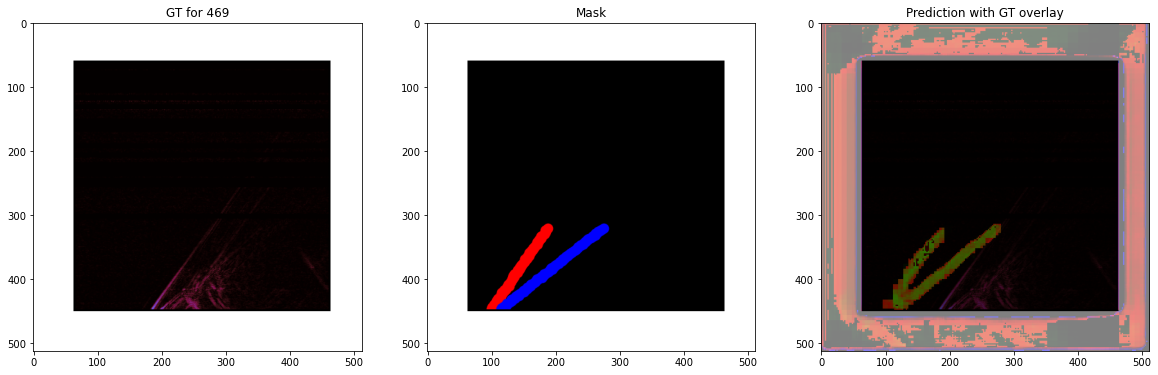

1/1 [==============================] - 0s 32ms/step


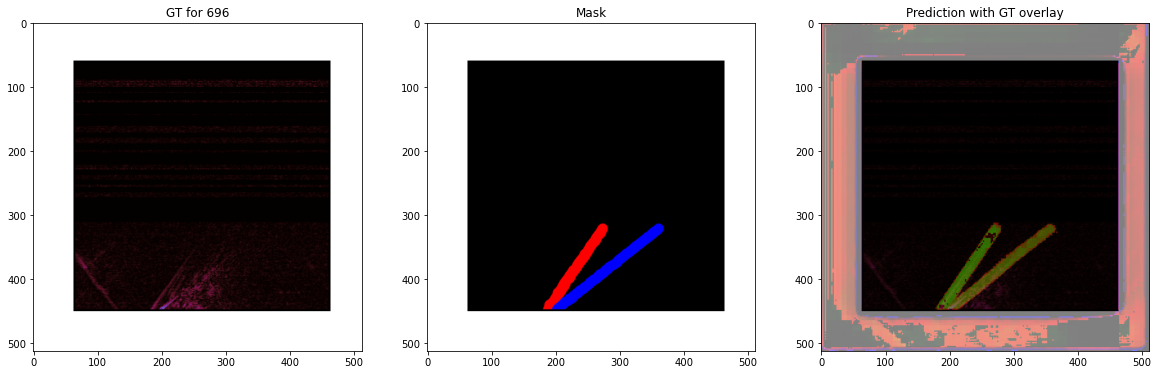

1/1 [==============================] - 0s 36ms/step


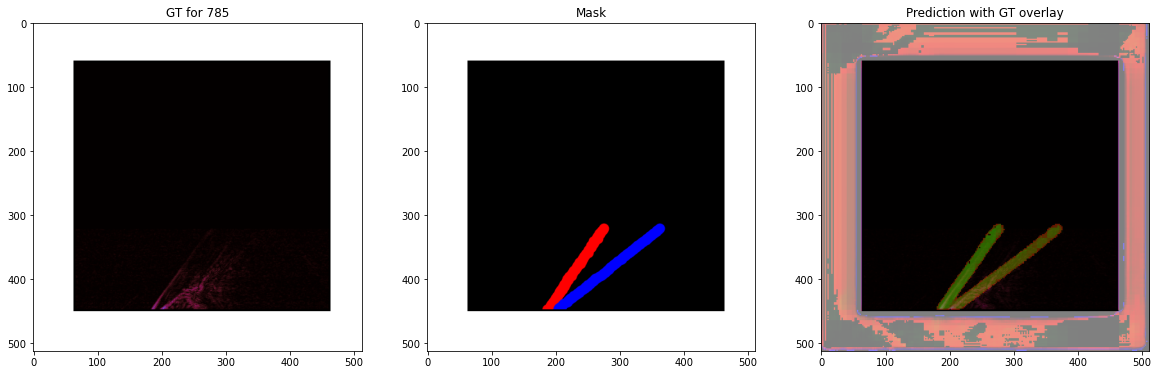

1/1 [==============================] - 0s 47ms/step


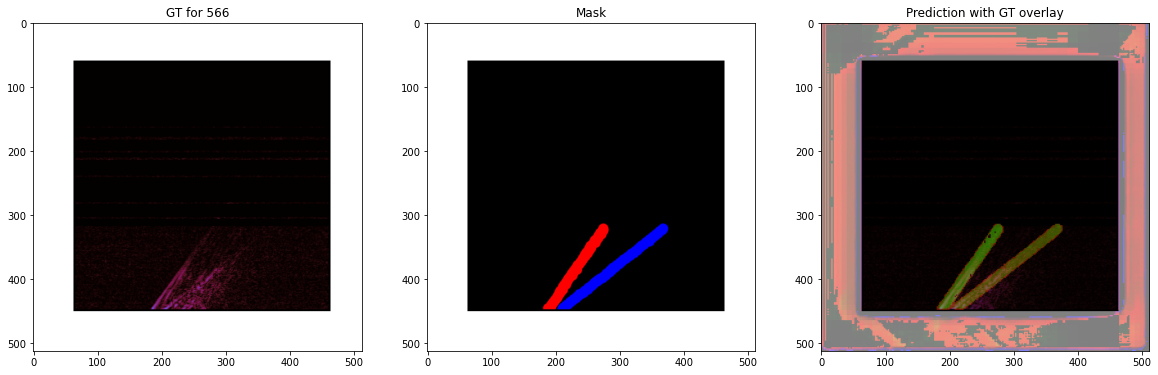

1/1 [==============================] - 0s 44ms/step


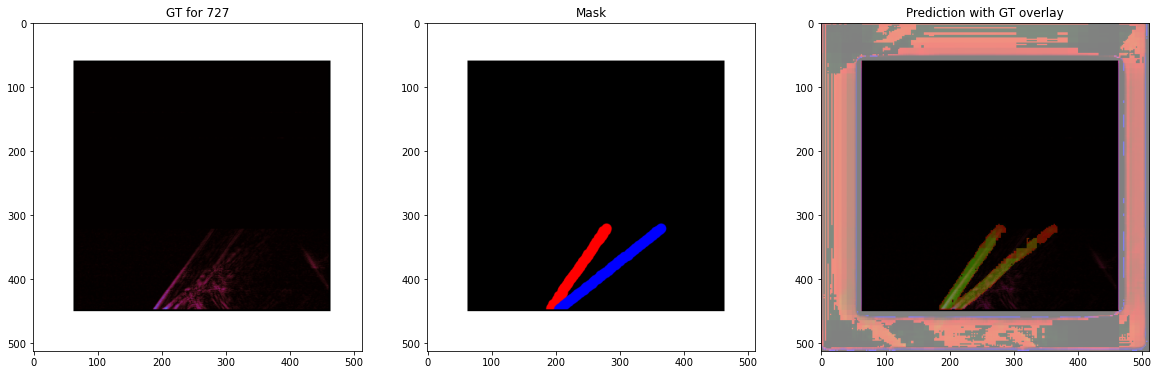

1/1 [==============================] - 0s 52ms/step


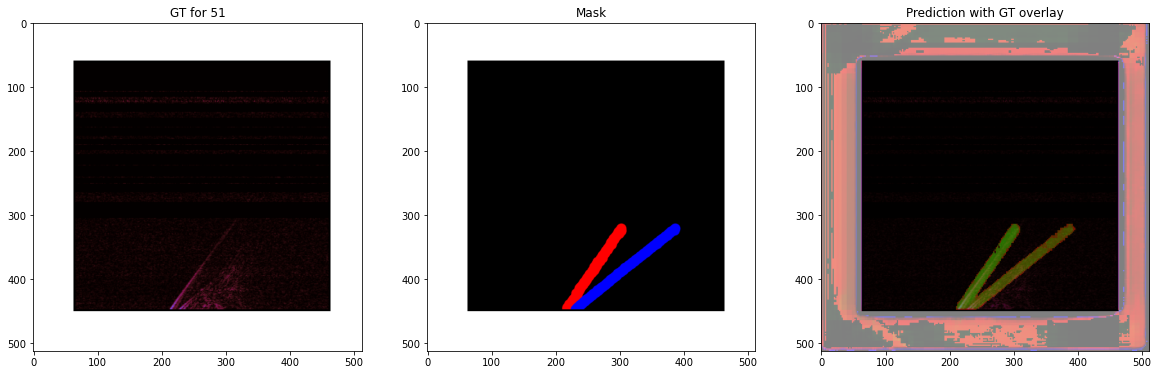

1/1 [==============================] - 0s 37ms/step


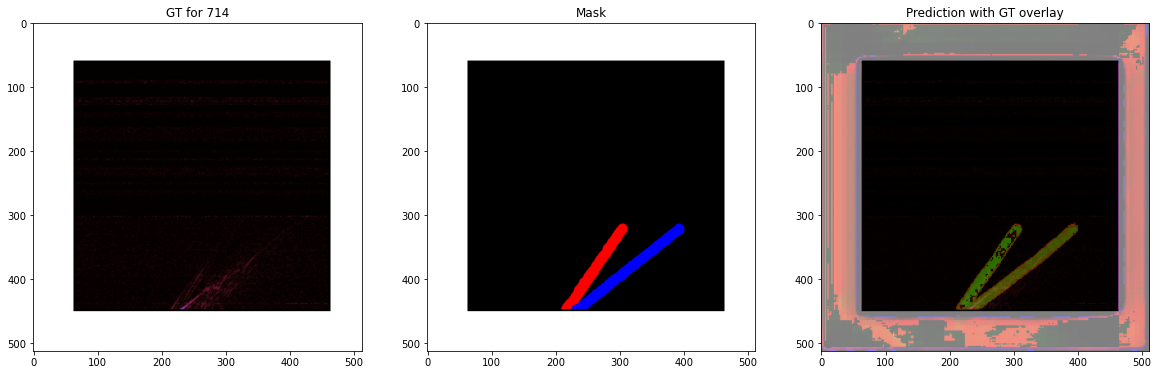

1/1 [==============================] - 0s 26ms/step


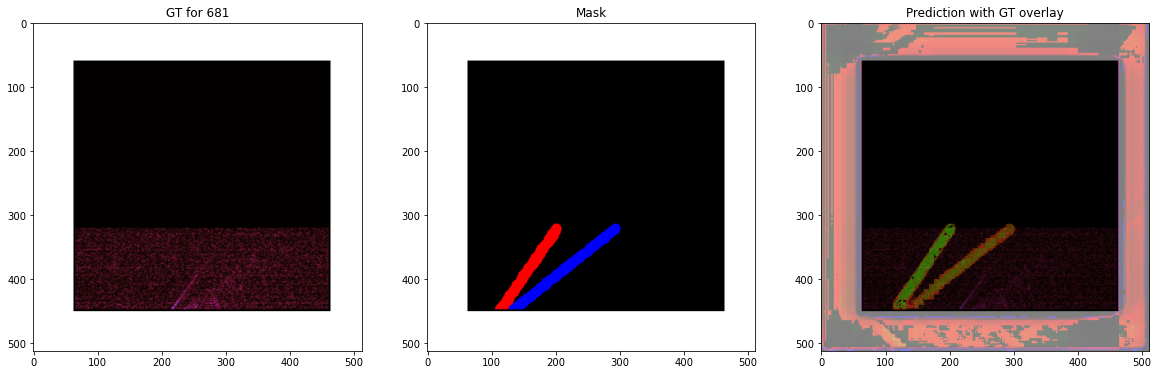

1/1 [==============================] - 0s 26ms/step


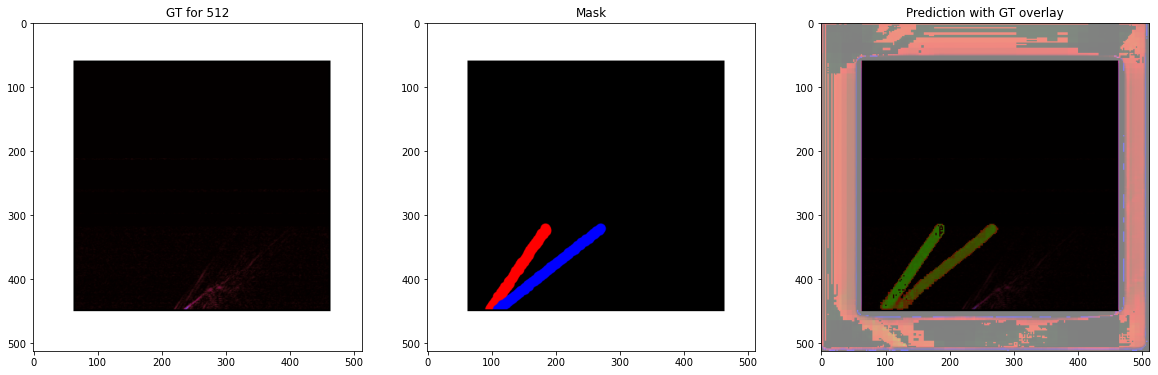

1/1 [==============================] - 0s 25ms/step


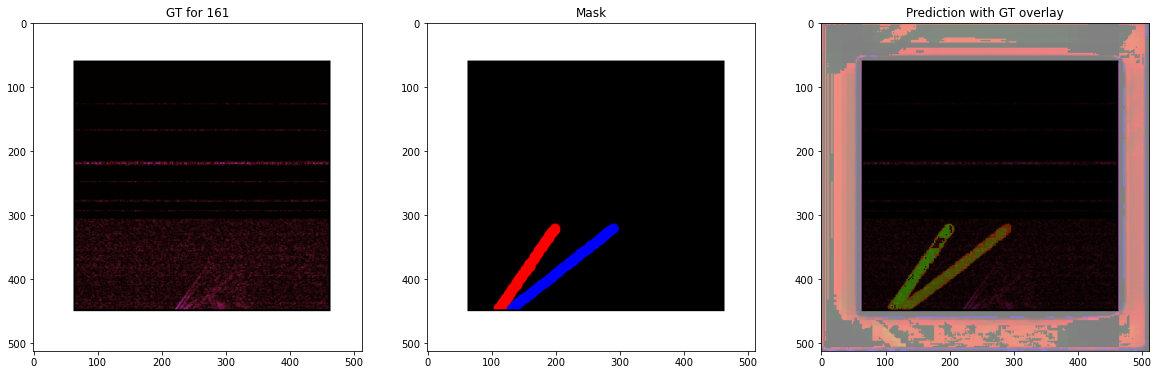

1/1 [==============================] - 0s 45ms/step


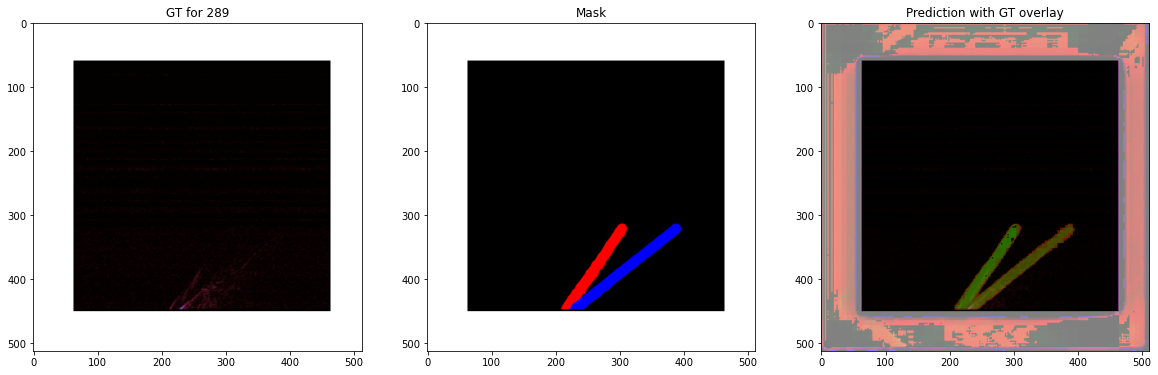

1/1 [==============================] - 0s 36ms/step


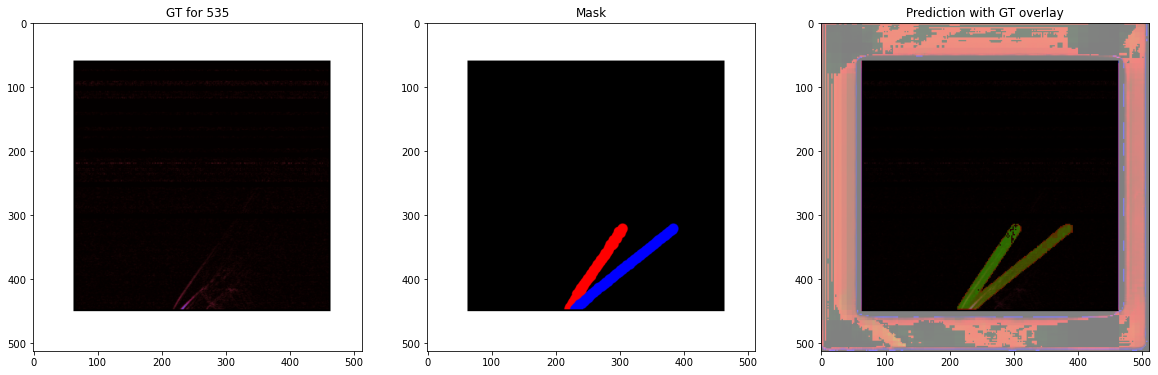

1/1 [==============================] - 0s 37ms/step


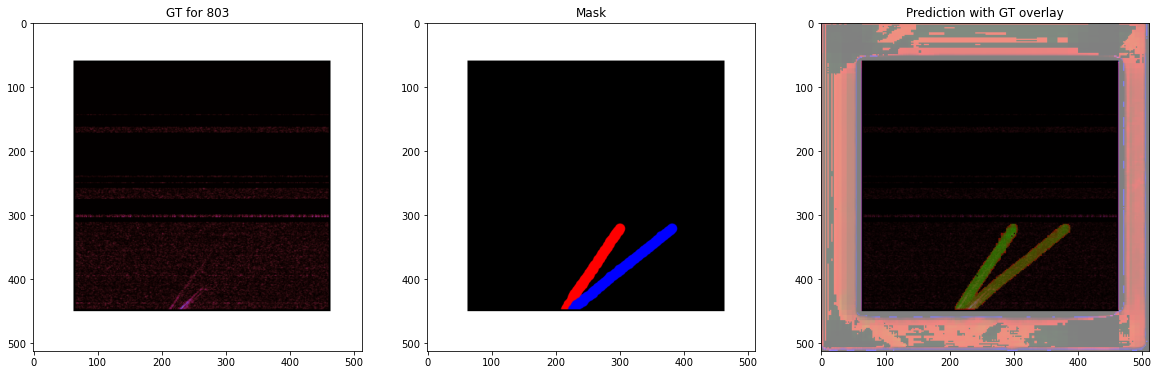

1/1 [==============================] - 0s 33ms/step


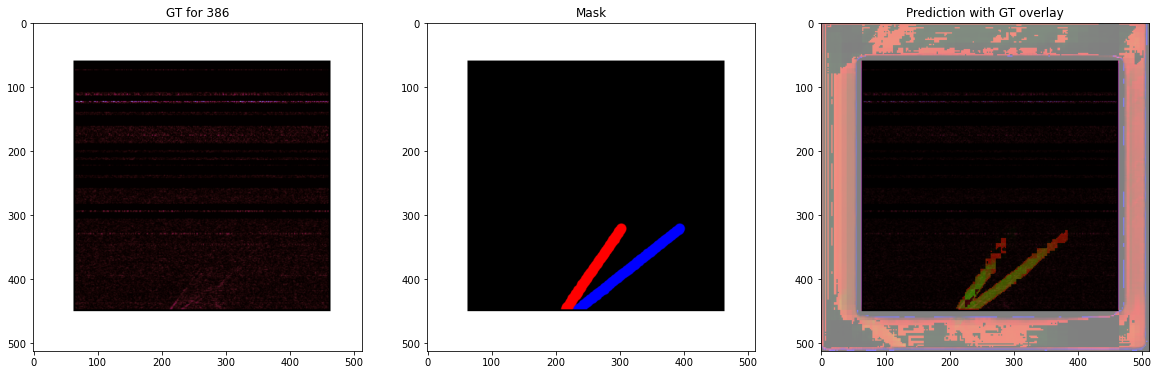

1/1 [==============================] - 0s 48ms/step


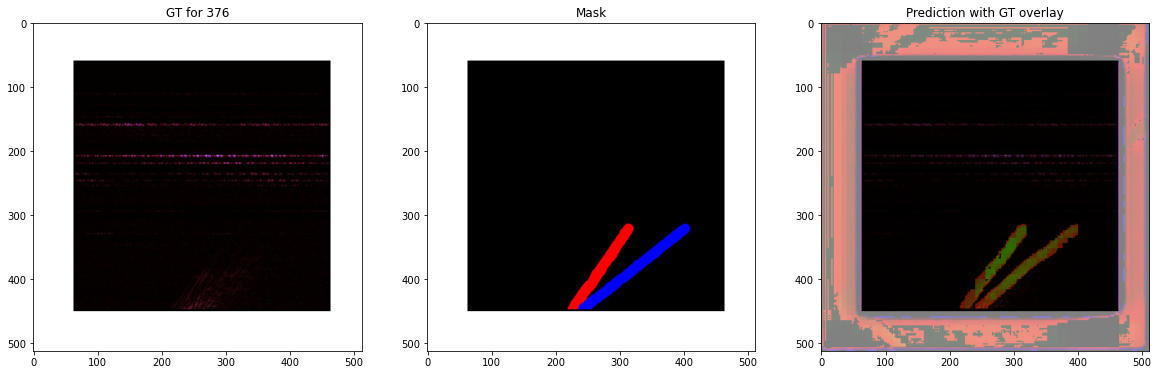

1/1 [==============================] - 0s 25ms/step


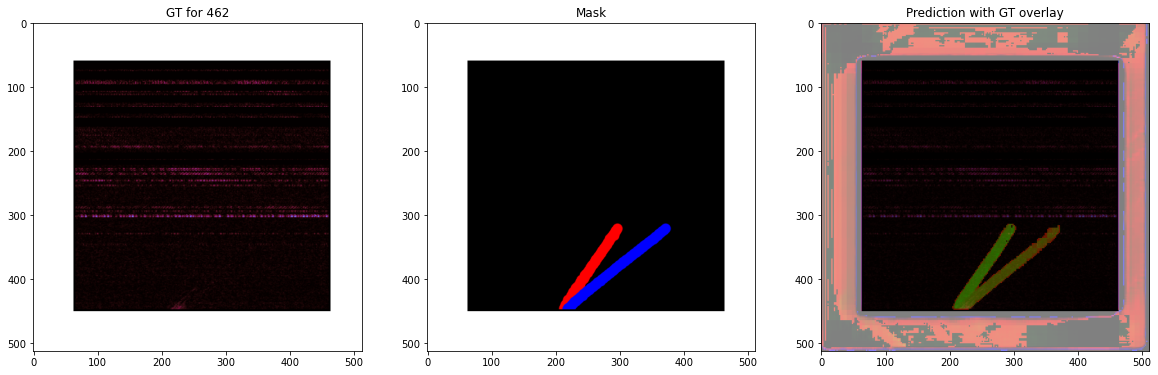

1/1 [==============================] - 0s 61ms/step


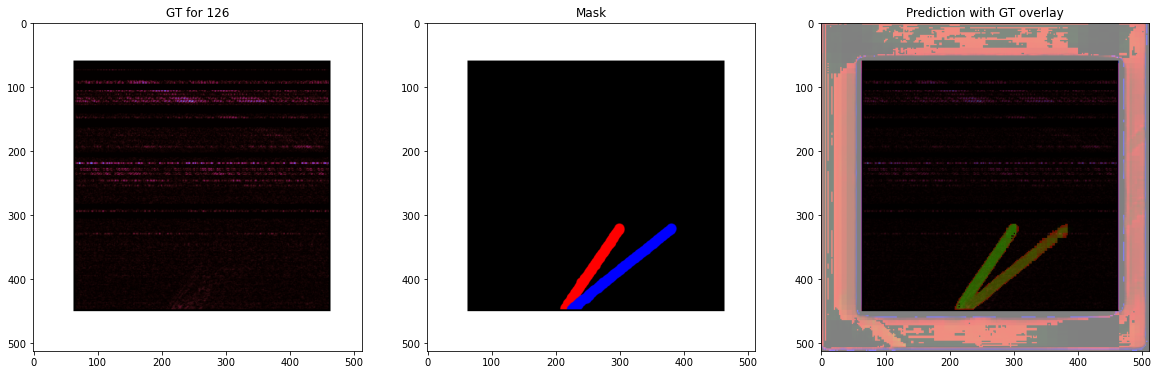

1/1 [==============================] - 0s 31ms/step


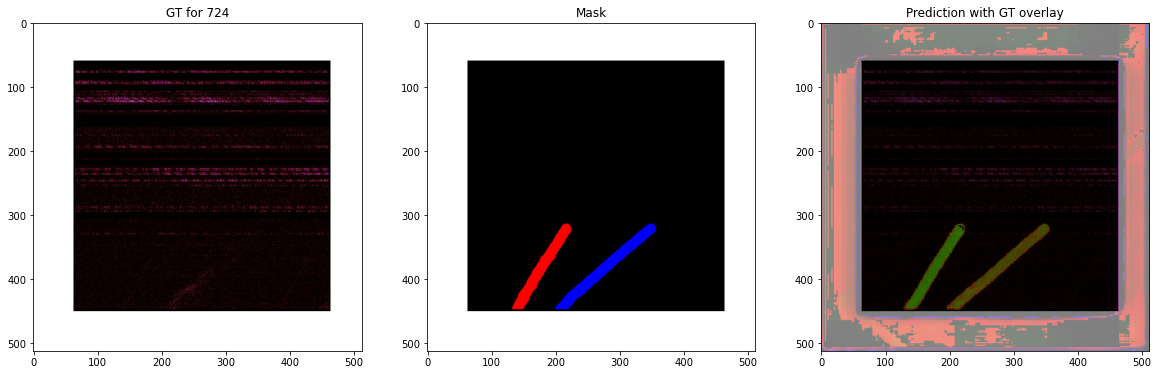

1/1 [==============================] - 0s 54ms/step


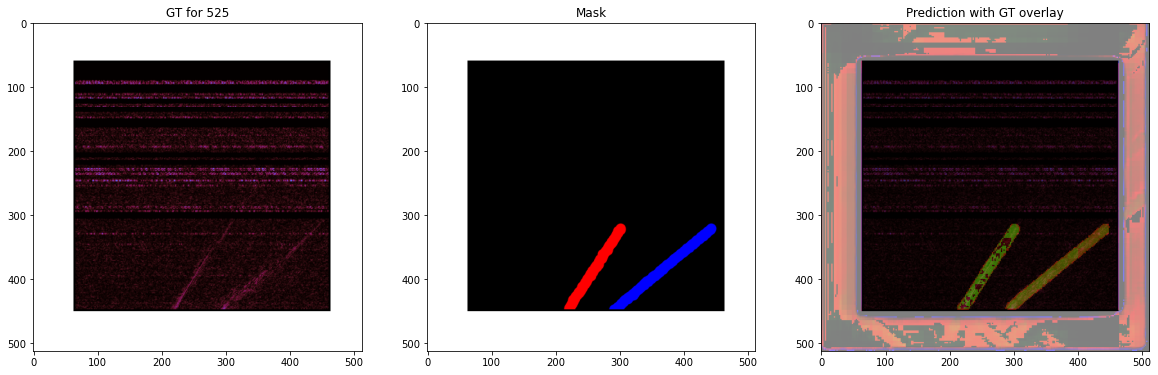

1/1 [==============================] - 0s 37ms/step


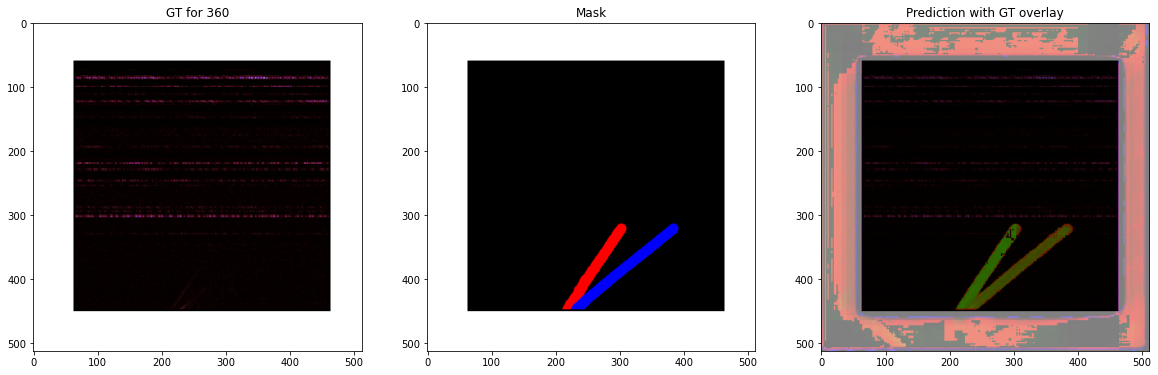

1/1 [==============================] - 0s 47ms/step


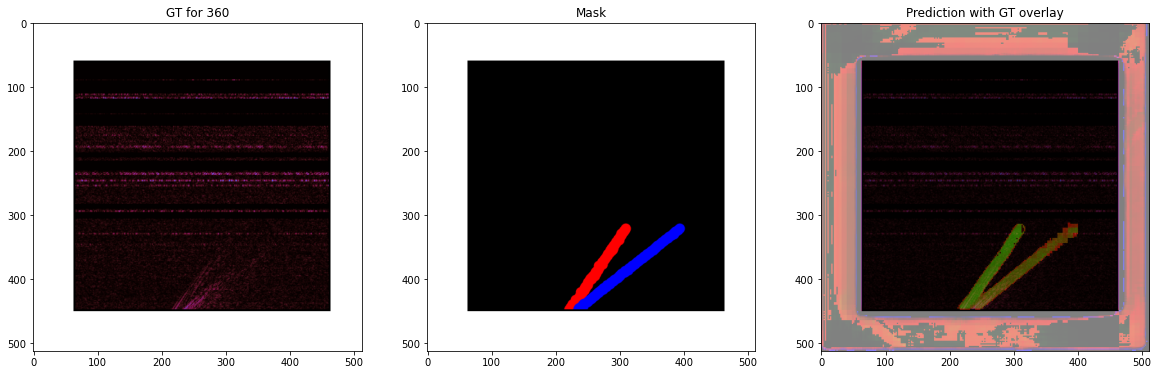

1/1 [==============================] - 0s 55ms/step


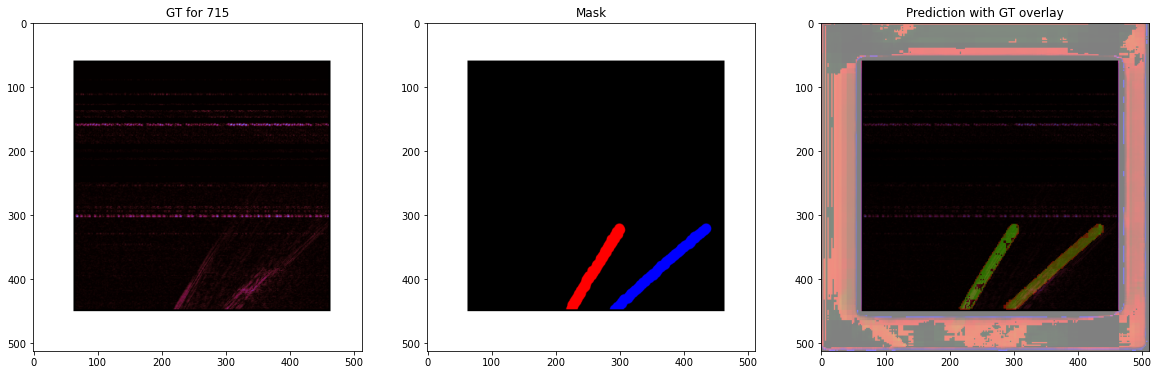

1/1 [==============================] - 0s 61ms/step


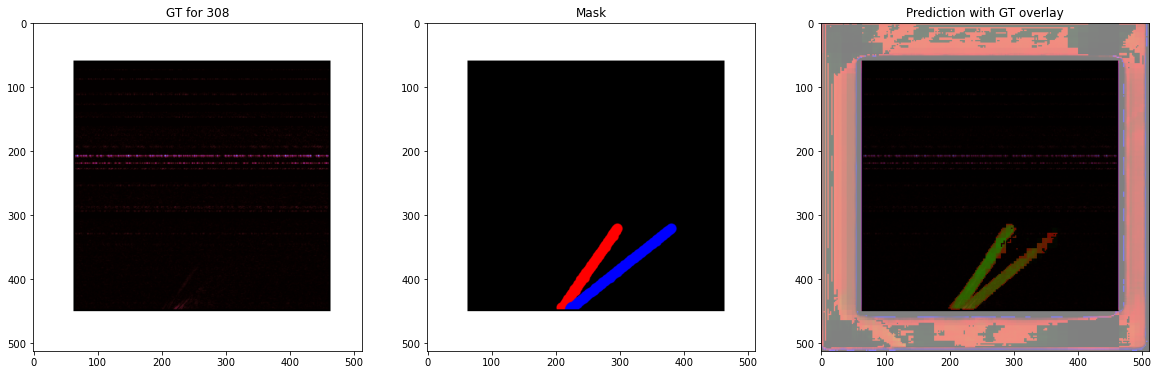

1/1 [==============================] - 0s 69ms/step


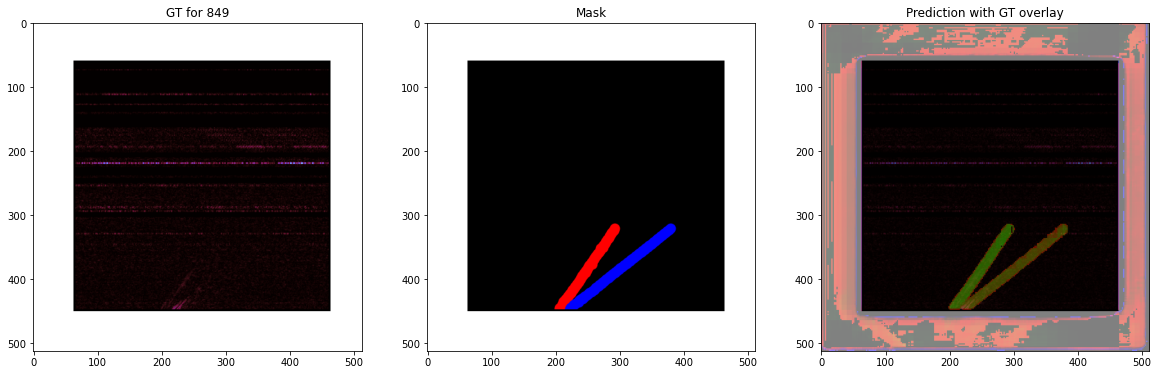

1/1 [==============================] - 0s 59ms/step


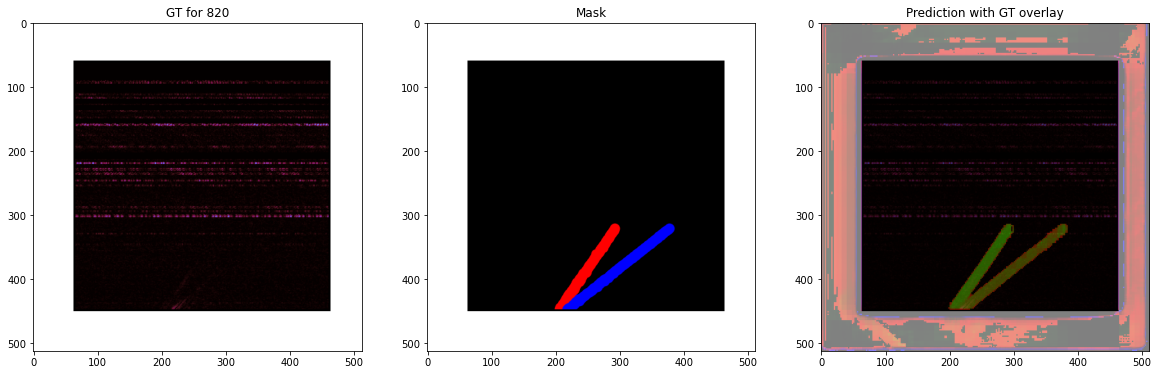

1/1 [==============================] - 0s 46ms/step


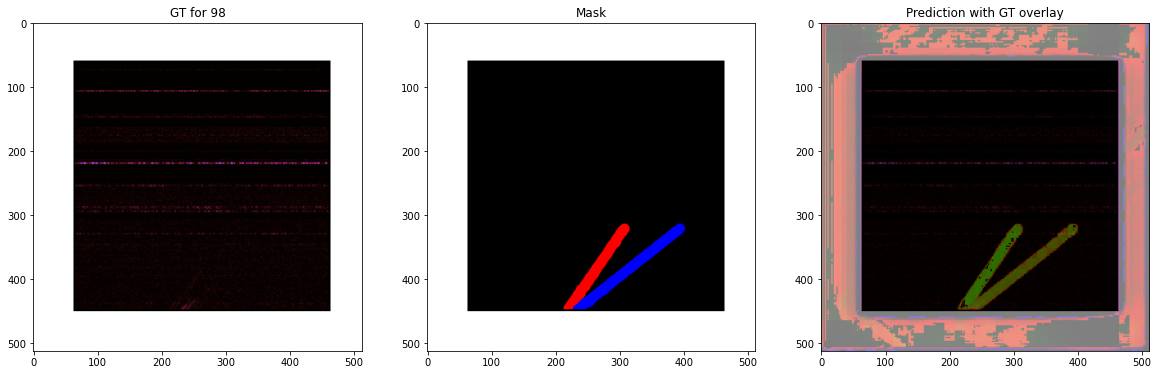

1/1 [==============================] - 0s 30ms/step


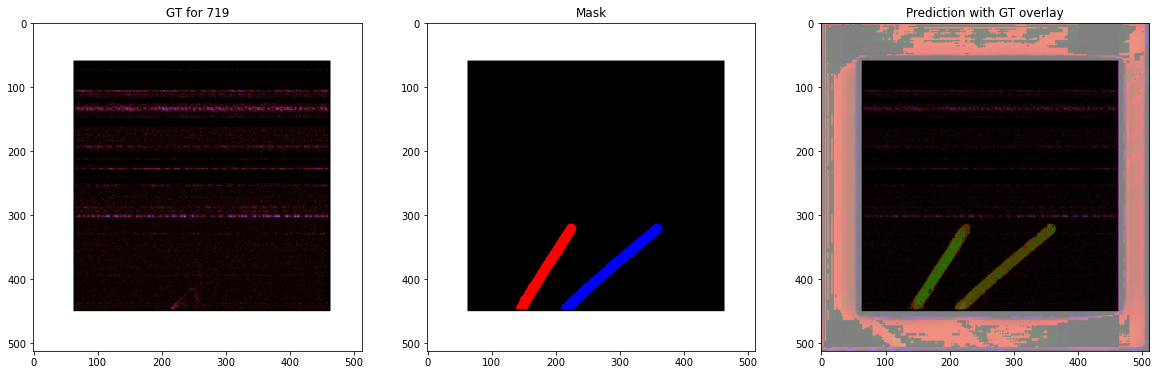

1/1 [==============================] - 0s 29ms/step


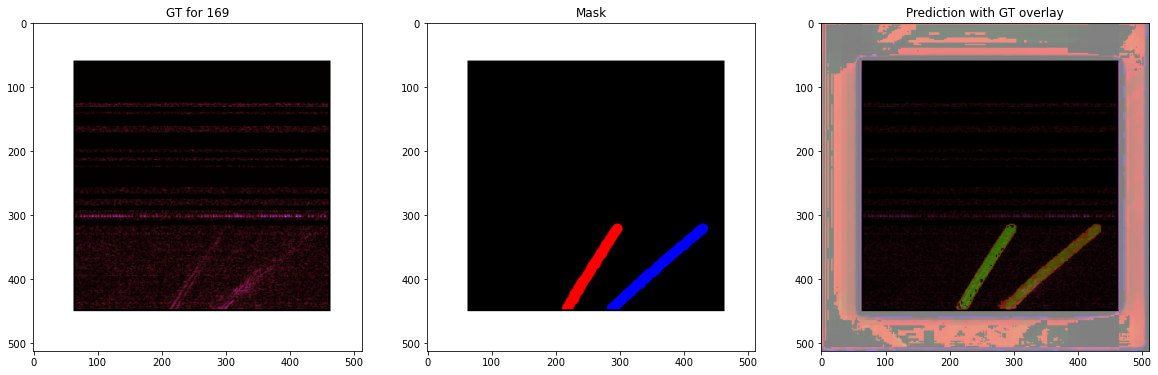

1/1 [==============================] - 0s 36ms/step


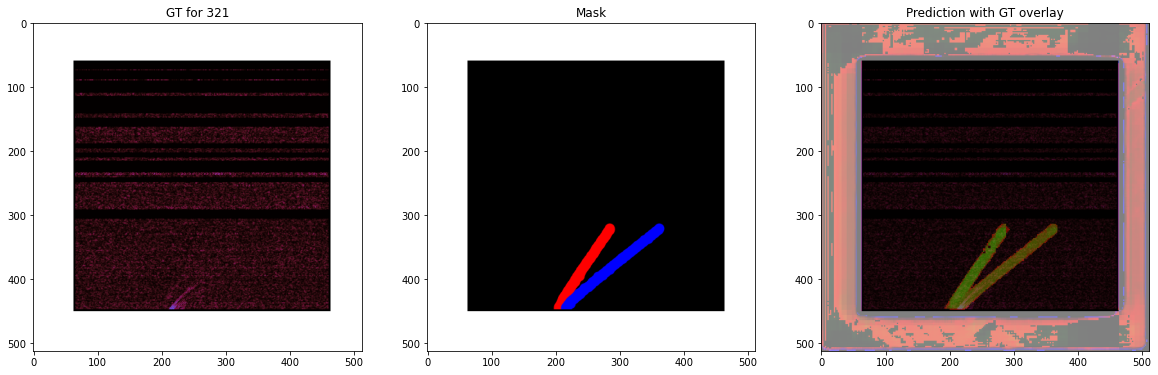

In [19]:
# tweak rgb thresholds to match prediction with masks

s = 512

def make_mask(pred):
    """ take prediction, each layer is a rbg channel"""

    r = pred[:,:,:,0]
    g = pred[:,:,:,1]
    b = pred[:,:,:,2]

    r_m = np.nanmax(r)
    g_m = np.nanmax(g)
    b_m = np.nanmax(b)

    n_r = (r/r_m).reshape((s,s))
    n_g = (g/g_m).reshape((s,s))
    n_b = (b/b_m).reshape((s,s))

    # set thresholds, manually...

    # n_r[n_r < .65] = 0 #.75
    # n_g[n_g < .66] = 0 #.66
    # n_b[n_b < .47] = 0 #.47

    #n_r[n_r > .99] = 0 #.85
    #n_g[n_g > .99] = 0 #.85
    #n_b[n_b > .99] = 0 #.85

    n_r[n_r > .90] = 0 #.85
    n_g[n_g > .90] = 0 #.85
    n_b[n_b > .90] = 0 #.85


    #return np.dstack((n_r,n_g,n_b))
    return np.dstack((n_r,n_g,n_b))

# test on first 10 random images

for i in range(1,30):

    j = random.randint(0, len(input_img_paths))

    f, axs = plt.subplots(1,3, figsize=(20,20))
    
    eg_file_img = '{}.png'.format(i)
    
    i_path = image_path + eg_file_img
    m_path = mask_path + eg_file_img

    #print('path', i_path)

    #img = cv2.imread(i_path, cv2.COLOR_BGR2RGB)
    #mask = cv2.imread(m_path, cv2.COLOR_BGR2RGB)

    img = cv2.imread(i_path)
    mask = cv2.imread(m_path)
    x = img
    #print('shape of image', np.shape(x))
    
    axs[0].imshow(x)
    axs[2].imshow(x)

    m = mask
    x = x.reshape(1,s,s,3)
    p = model.predict(x)

    axs[1].imshow(m)
    
    axs[2].imshow(make_mask(p), alpha=0.5)

    axs[0].set_title('GT for ' +str(j))
    axs[1].set_title('Mask')
    axs[2].set_title('Prediction with GT overlay')

    plt.show()

In [ ]:
while True:pass
